In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from einops import rearrange
import torch.nn.utils.weight_norm as weight_norm
from torch.nn import functional as F

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()

1.DCCN

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


epoch1,loss0.0019,train acc 0.798762,val acc 0.848
epoch2,loss0.0017,train acc 0.869581,val acc 0.887
epoch3,loss0.0016,train acc 0.893254,val acc 0.906
epoch4,loss0.0016,train acc 0.905949,val acc 0.904
epoch5,loss0.0015,train acc 0.915472,val acc 0.922
epoch6,loss0.0015,train acc 0.921045,val acc 0.919
epoch7,loss0.0015,train acc 0.924812,val acc 0.929
epoch8,loss0.0015,train acc 0.928109,val acc 0.922
epoch9,loss0.0015,train acc 0.930936,val acc 0.927
epoch10,loss0.0015,train acc 0.933645,val acc 0.938
epoch11,loss0.0015,train acc 0.935246,val acc 0.941
epoch12,loss0.0015,train acc 0.937184,val acc 0.940
epoch13,loss0.0015,train acc 0.937720,val acc 0.939
epoch14,loss0.0015,train acc 0.938829,val acc 0.928
epoch15,loss0.0014,train acc 0.940929,val acc 0.946
epoch16,loss0.0014,train acc 0.942992,val acc 0.941
epoch17,loss0.0014,train acc 0.942177,val acc 0.947
epoch18,loss0.0014,train acc 0.942581,val acc 0.941
epoch19,loss0.0014,train acc 0.945026,val acc 0.943
epoch20,loss0.0014,tr

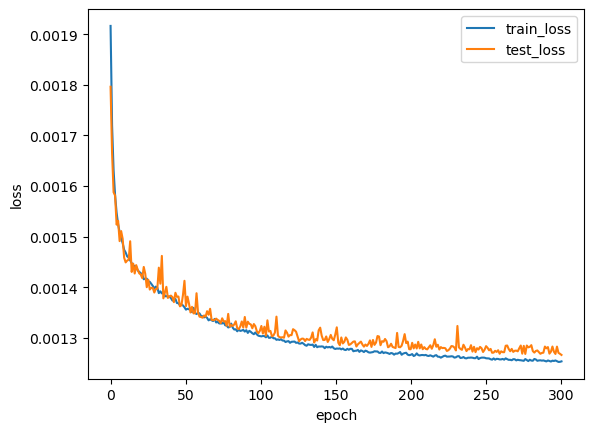

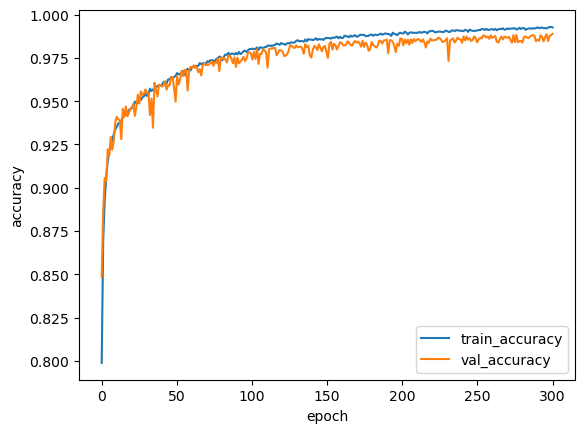

Accuracy on test set : 0.988
test precision: 0.9843011562257665  test recall: 0.9863915529788818  test f1_score: 0.9852802772959809


In [4]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=1,S=1):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_b1 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b2 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//4,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b3 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=variable_dim*channel_dim)
        self.conv_b4 =nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]
        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y1 = self.conv_b1(x)
        y2 = self.conv_b2(x)
        y3 = self.conv_b3(x)
        y4 = self.conv_b4(x)
        y = y1 + y2 +y3 + y4 + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/DCCN_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/DCCN_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

2.LSTM

epoch1,loss0.0021,train acc 0.772608,val acc 0.789
epoch2,loss0.0019,train acc 0.790494,val acc 0.798
epoch3,loss0.0019,train acc 0.791757,val acc 0.797
epoch4,loss0.0021,train acc 0.761770,val acc 0.787
epoch5,loss0.0019,train acc 0.789085,val acc 0.791
epoch6,loss0.0019,train acc 0.792139,val acc 0.797
epoch7,loss0.0019,train acc 0.793211,val acc 0.797
epoch8,loss0.0019,train acc 0.796486,val acc 0.802
epoch9,loss0.0019,train acc 0.802881,val acc 0.801
epoch10,loss0.0019,train acc 0.816428,val acc 0.832
epoch11,loss0.0018,train acc 0.833654,val acc 0.839
epoch12,loss0.0018,train acc 0.840255,val acc 0.844
epoch13,loss0.0018,train acc 0.850777,val acc 0.867
epoch14,loss0.0017,train acc 0.864977,val acc 0.866
epoch15,loss0.0017,train acc 0.869970,val acc 0.865
epoch16,loss0.0017,train acc 0.873627,val acc 0.876
epoch17,loss0.0017,train acc 0.880654,val acc 0.883
epoch18,loss0.0017,train acc 0.878319,val acc 0.880
epoch19,loss0.0016,train acc 0.889979,val acc 0.897
epoch20,loss0.0016,tr

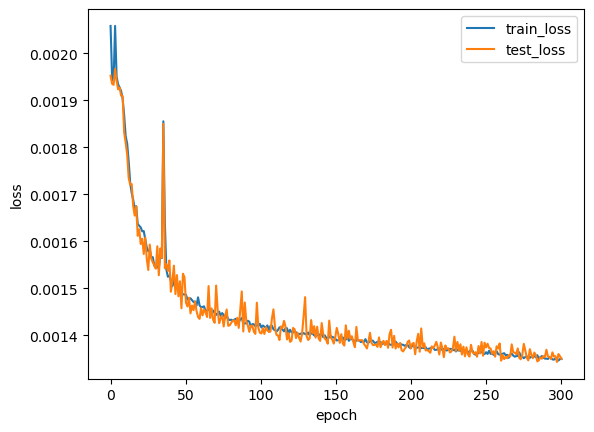

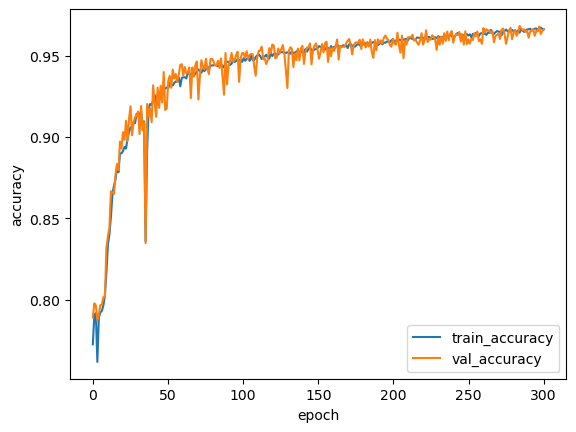

Accuracy on test set : 0.966
test precision: 0.9529384631170259  test recall: 0.9667305916578447  test f1_score: 0.9596330857413665


In [5]:
class LSTMNet(nn.Module):
    def __init__(self,batch_size,input_features,hidden_size,num_layers,device="cuda"):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_features,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_size,out_features=hidden_size//2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_size//2,out_features=2),
            nn.Sigmoid()
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    def forward(self,x):
        #print("x",x.shape)
        h,c = (torch.zeros(self.num_layers,self.batch_size,self.hidden_size).to(x.device) for _ in range(2))
        H,(h,c) = self.lstm(x,(h,c))
        out = H[:,-1,:].squeeze()
        out = self.classifier(out)
        out = out.squeeze()
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/LSTM_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy
net = LSTMNet(batch_size=batch_size,input_features=train_set.X.shape[-1],hidden_size=256,num_layers=1)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/LSTM_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

3.TCN

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch1,loss0.0023,train acc 0.713551,val acc 0.781
epoch2,loss0.0020,train acc 0.776683,val acc 0.780
epoch3,loss0.0020,train acc 0.778695,val acc 0.784
epoch4,loss0.0020,train acc 0.780824,val acc 0.789
epoch5,loss0.0020,train acc 0.784554,val acc 0.789
epoch6,loss0.0020,train acc 0.789165,val acc 0.796
epoch7,loss0.0019,train acc 0.793204,val acc 0.801
epoch8,loss0.0019,train acc 0.796119,val acc 0.806
epoch9,loss0.0019,train acc 0.799151,val acc 0.811
epoch10,loss0.0019,train acc 0.802184,val acc 0.802
epoch11,loss0.0019,train acc 0.806009,val acc 0.821
epoch12,loss0.0019,train acc 0.811391,val acc 0.825
epoch13,loss0.0019,train acc 0.816414,val acc 0.830
epoch14,loss0.0019,train acc 0.821238,val acc 0.834
epoch15,loss0.0019,train acc 0.826385,val acc 0.838
epoch16,loss0.0018,train acc 0.831341,val acc 0.832
epoch17,loss0.0018,train acc 0.834491,val acc 0.840
epoch18,loss0.0018,train acc 0.837274,val acc 0.850
epoch19,loss0.0018,train acc 0.840137,val acc 0.852
epoch20,loss0.0018,tr

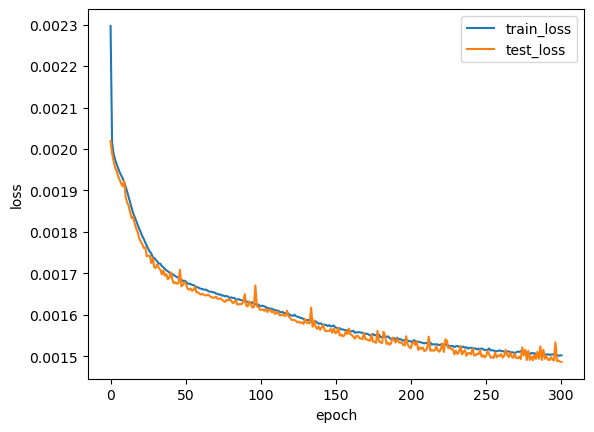

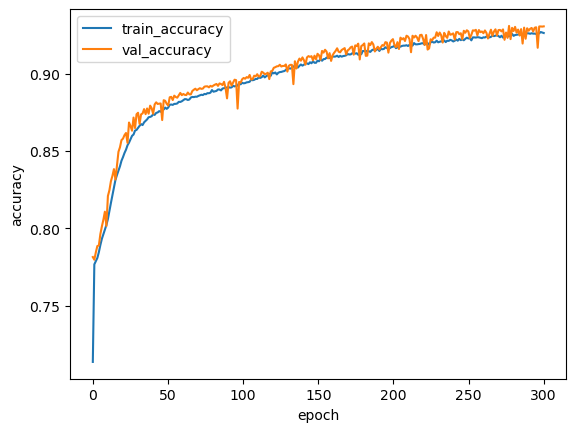

Accuracy on test set : 0.925
test precision: 0.9099952169963688  test recall: 0.9100836267083539  test f1_score: 0.9097323624151039


In [6]:
class Chomp1d(nn.Module):
    def __init__(self,chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = int(chomp_size)
    def forward(self,x):
        return x[:,:,0:-self.chomp_size].contiguous()

class TCNResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,kernelsize,dilation):
        super(TCNResidualBlock,self).__init__()
        self.ke = int(kernelsize+(kernelsize-1)*(dilation-1))
        self.conv = nn.Sequential(
            weight_norm(nn.Conv1d(inchannel,outchannel,kernel_size=kernelsize,dilation=dilation,padding=self.ke-1)),
            Chomp1d(self.ke-1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            weight_norm(nn.Conv1d(outchannel,outchannel,kernel_size=kernelsize,dilation=dilation,padding=self.ke-1)),
            Chomp1d(self.ke-1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        self.conv1x1 = nn.Sequential(
            weight_norm(nn.Conv1d(inchannel,outchannel,kernel_size=1)),
        )

    def forward(self,X):
        Y = self.conv(X)
        #print("Y:",Y.shape)
        X = self.conv1x1(X)
        #print("X:",X.shape)
        out = F.relu(X+Y)
        return out
class TCNet(nn.Module):
    def __init__(self,seq_len,inchannels,outchannels,kernel_size,dilations):
        super(TCNet,self).__init__()
        self.features = nn.Sequential(
            TCNResidualBlock(inchannel=inchannels[0],outchannel=outchannels[0],kernelsize=kernel_size[0],dilation=dilations[0]),
            TCNResidualBlock(inchannel=inchannels[1],outchannel=outchannels[1],kernelsize=kernel_size[1],dilation=dilations[1]),
            TCNResidualBlock(inchannel=inchannels[2],outchannel=outchannels[2],kernelsize=kernel_size[2],dilation=dilations[2])
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3*seq_len,out_features=3*seq_len//2),
            nn.LeakyReLU(),
            nn.Linear(in_features=3*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    def forward(self,X):
        #in_channels代表输入序列的特征维数
        #数据集输入为batch_size * seq_length * features
        #Conv1d要求输入为batch_size*features*seq_length
        X = X.permute(0,2,1).contiguous()
        #print("X:",X.shape)
        features = self.features(X)
        #batch_size*features(output_features)*seq_length 类似LSTM的H矩阵
        out = self.flatten(features)
        #batch_size*features*pred_len
        out = self.classifier(out)
        #batch_size*pred_len*features
        return out
def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/TCN_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy
net = TCNet(seq_len=100,inchannels=[train_set.X.shape[-1],train_set.X.shape[-1]*2,train_set.X.shape[-1]*4],outchannels=[train_set.X.shape[-1]*2,train_set.X.shape[-1]*4,train_set.X.shape[-1]],kernel_size=[7,5,3],dilations=[1,2,4])
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/TCN_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

4.SCINet

epoch1,loss0.0021,train acc 0.771264,val acc 0.802
epoch2,loss0.0019,train acc 0.801692,val acc 0.815
epoch3,loss0.0019,train acc 0.813183,val acc 0.835
epoch4,loss0.0019,train acc 0.820841,val acc 0.841
epoch5,loss0.0019,train acc 0.827751,val acc 0.843
epoch6,loss0.0018,train acc 0.832156,val acc 0.845
epoch7,loss0.0018,train acc 0.837744,val acc 0.853
epoch8,loss0.0018,train acc 0.841731,val acc 0.854
epoch9,loss0.0018,train acc 0.843684,val acc 0.853
epoch10,loss0.0018,train acc 0.846481,val acc 0.860
epoch11,loss0.0018,train acc 0.848743,val acc 0.862
epoch12,loss0.0018,train acc 0.850725,val acc 0.864
epoch13,loss0.0018,train acc 0.852121,val acc 0.865
epoch14,loss0.0018,train acc 0.853295,val acc 0.863
epoch15,loss0.0018,train acc 0.855197,val acc 0.863
epoch16,loss0.0018,train acc 0.855403,val acc 0.868
epoch17,loss0.0018,train acc 0.857598,val acc 0.868
epoch18,loss0.0018,train acc 0.857466,val acc 0.863
epoch19,loss0.0017,train acc 0.857995,val acc 0.871
epoch20,loss0.0017,tr

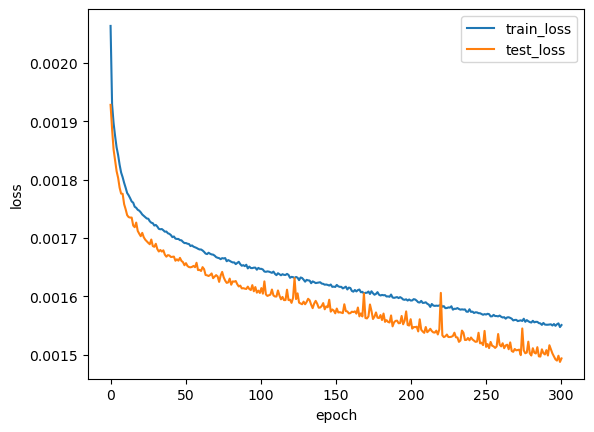

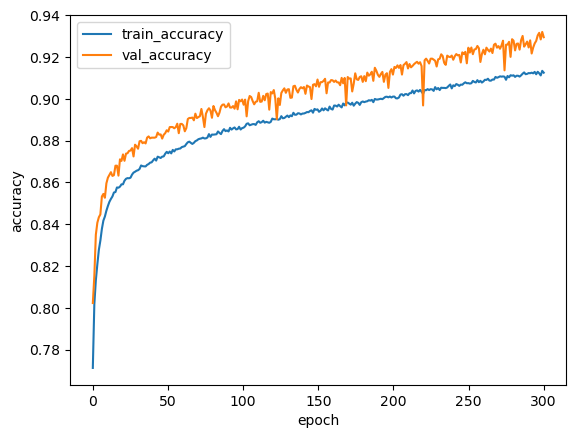

Accuracy on test set : 0.914
test precision: 0.9053764772816492  test recall: 0.887331511417586  test f1_score: 0.8958822844213259


In [7]:
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))

class Interactor(nn.Module):
    # in_planes input_dim
    def __init__(self, in_planes, splitting=True,
                 kernel = 5, dropout=0.5, groups = 1, hidden_size = 1, INN = True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        #输入输出长度等长
        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1 #by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1 #by default: stride==1 

        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1 # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            #input_dim == in_planes == channels
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        #输入 batch_size seq_len feature_dim
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)# B L D
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update) # B D L 与 Conv1d的输出 N C L对应

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)

class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes = in_planes, splitting=True,
                                kernel = kernel, dropout=dropout, groups = groups, hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update) # B D L

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes= in_planes, kernel = kernel_size, dropout = dropout, groups =groups , hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x) # B D L
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

class SCINet_Tree(nn.Module):
    '''
    递归 二叉树的格式
    '''
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level


        self.workingblock = LevelSCINet(
            in_planes = in_planes,
            kernel_size = kernel_size,
            dropout = dropout,
            groups= groups,
            hidden_size = hidden_size,
            INN = INN)


        if current_level!=0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)

    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2) #L, B, D
        #把序列长度维度调到第0维再拼接
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen): #偶 奇 偶 ...
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: #奇数序列<偶数序列 0 1 2
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_,0).permute(1,0,2) #B, L, D        #Conv1d input N C L

    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level ==0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)#输出一条最终序列
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes = in_planes,
            current_level = num_levels-1,
            kernel_size = kernel_size,
            dropout =dropout ,
            groups = groups,
            hidden_size = hidden_size,
            INN = INN)

    def forward(self, x):

        x= self.SCINet_Tree(x)

        return x

class SCICNet(nn.Module):
    def __init__(self, n_classes=2, input_len=100, input_dim = 3, hid_size = 1,
                 num_levels = 2, groups = 1, kernel = 5, dropout = 0.5):
        super(SCICNet, self).__init__()
        self.input_len = input_len
        self.output_len = n_classes
        self.input_dim = input_dim
        self.num_levels = num_levels
        self.kernel_size = kernel
        self.dropout = dropout
        self.groups = groups
        self.hidden_size = hid_size

        self.features = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN = True)

        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(input_len*input_dim,input_len*input_dim//2),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(input_len*input_dim//2,n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        #print("x:",x.shape)
        #输入B L D
        assert self.input_len % (np.power(2, self.num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        y = self.features(x)+x #B L D 32 96 3
        y = self.flatten(y)
        out = self.classifier(y)
        return out

net = SCICNet()
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/SCINet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/SCINet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

5.NLinear

epoch1,loss0.0020,train acc 0.796295,val acc 0.847
epoch2,loss0.0018,train acc 0.846915,val acc 0.861
epoch3,loss0.0018,train acc 0.858795,val acc 0.866
epoch4,loss0.0017,train acc 0.864867,val acc 0.874
epoch5,loss0.0017,train acc 0.870771,val acc 0.880
epoch6,loss0.0017,train acc 0.875419,val acc 0.881
epoch7,loss0.0017,train acc 0.879839,val acc 0.885
epoch8,loss0.0017,train acc 0.882739,val acc 0.889
epoch9,loss0.0017,train acc 0.886814,val acc 0.894
epoch10,loss0.0016,train acc 0.889032,val acc 0.893
epoch11,loss0.0016,train acc 0.891073,val acc 0.898
epoch12,loss0.0016,train acc 0.893232,val acc 0.899
epoch13,loss0.0016,train acc 0.895067,val acc 0.900
epoch14,loss0.0016,train acc 0.895978,val acc 0.902
epoch15,loss0.0016,train acc 0.897131,val acc 0.901
epoch16,loss0.0016,train acc 0.899245,val acc 0.904
epoch17,loss0.0016,train acc 0.899524,val acc 0.904
epoch18,loss0.0016,train acc 0.900765,val acc 0.905
epoch19,loss0.0016,train acc 0.901272,val acc 0.906
epoch20,loss0.0016,tr

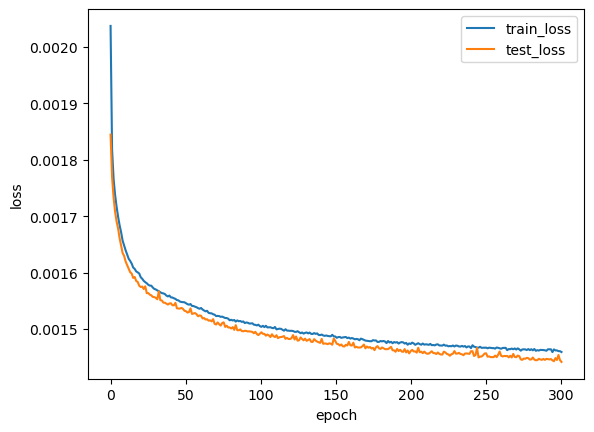

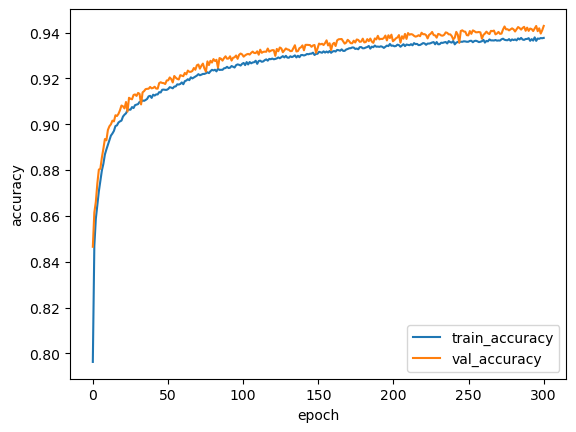

Accuracy on test set : 0.939
test precision: 0.9456934647155857  test recall: 0.9035122710191762  test f1_score: 0.9237923042392747


In [8]:
class NLinear(nn.Module):
    def __init__(self,seq_len=100,channels=3):
        super(NLinear,self).__init__()
        self.seq_len = seq_len
        self.channels = channels
        self.Linear = nn.ModuleList()
        for i in range(self.channels):
            self.Linear.append(nn.Linear(self.seq_len,self.seq_len))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(self.seq_len*self.channels,self.seq_len*self.channels//2),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(self.seq_len*self.channels//2,2),
            nn.Sigmoid()
        )        
    
    def forward(self,x):
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        output = torch.zeros([x.size(0),self.seq_len,x.size(2)],dtype=x.dtype).to(x.device)
        for i in range(self.channels):
            output[:,:,i] = self.Linear[i](x[:,:,i])
        x = output
        x = x + seq_last
        y = self.flatten(x)
        z = self.classifier(y)
        return z
net = NLinear()
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/NLinear_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/NLinear_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)
